In [1]:
import numpy as np
import spacy
from DataReader.XMLReader import get_essays
from matplotlib import pyplot as plt
from collections import Counter

import operator
from scipy import stats
import math

## 1. Load dataset

- Several levels can be combined (e.g. levels = [1,2,3])
- bin_score reduces the number of scores to 10 (see comment below)

In [2]:
bin_scores = True # bin scores (1-10 => bin 1, 11-20 => bin 2, ... , 91 - 100 => bin 10)

dataset_path = '/home/simon/Downloads/efcamdat/'
levels = ['c1']


from concurrent.futures import ThreadPoolExecutor, as_completed

essays = []
scores = []

result = {}
with ThreadPoolExecutor(max_workers=4) as executor:
    
    futures_level = {executor.submit(get_essays, dataset_path + 'level_' + level + '.xml'): level for level in levels}
    for future in as_completed(futures_level):
        level = futures_level[future]
        try:
            level_result = future.result()
            result[level] = level_result
        except Exception as exc:
            print('%r generated an exception: %s' % (level, exc))
        
    for level in levels:
        essays += result[level][0]
        scores += result[level][1]
scores = np.array(scores)
if bin_scores:
    scores = np.round(scores/10)
print("done")
print("Number of essays: " + str(len(essays)))

done
Number of essays: 10000


## 2. Extract features

In [3]:
from essay_evaluation.pipeline import FeatureCollector
from essay_evaluation.lexical_variation import LexicalVariationFeatures, features_lv
from essay_evaluation.lexical_sophistication import LexicalSophisticationFeatures, features_ls
from essay_evaluation.lexical_accuracy import SpellChecker, LexicalAccuracy
nlp = spacy.load('en_core_web_sm')
# we only need the tokenizer from spaCy
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')

# add lv features
#lv_feature_extractor = LexicalVariationFeatures() 
#nlp.add_pipe(lv_feature_extractor, name=lv_feature_extractor.name, last=True)

# add ls features

#ls_feature_extractor = LexicalSophisticationFeatures() 
#nlp.add_pipe(ls_feature_extractor, name=ls_feature_extractor.name, last=True)

# add la features
spell_checker = SpellChecker()
nlp.add_pipe(spell_checker, spell_checker.name, last=True)
la_feature_extractor = LexicalAccuracy()
nlp.add_pipe(la_feature_extractor, la_feature_extractor, last=True)

# add the feature collector to get a nice feature matrix
feature_collector = FeatureCollector()
nlp.add_pipe(feature_collector, name=feature_collector.name, last=True)


# Do not change the order of the feature names! The feature collector adds the features in a predefined order to the 
# feature matrix
feature_names = []
#feature_names += features_lv
#feature_names += features_ls
feature_names += la_feature_extractor.feature_names



docs = list(nlp.pipe(essays, batch_size=500))

### Filter outliers

In [4]:
feature_matrix = np.array(feature_collector.feature_matrix)
def is_outlier(doc):
    return (len(doc) < 5 or len(doc) > 600 or
            doc._.features[6] == 0  or #LV_HDD is 0 
            doc._.features[13] > 2 or # LV_MATTR < 2
            doc._.features[7] > 300 or # LV_DUGA
            False
           )# add more outlier conditions here

docfilter = docs[:]

#for doc in docfilter:
#    if is_outlier(doc):
#        index = docs.index(doc)
#        del docs[index]
#        del essays[index]
#        feature_matrix = np.delete(feature_matrix,index,0)
#        scores = np.delete(scores,index,0)
#        


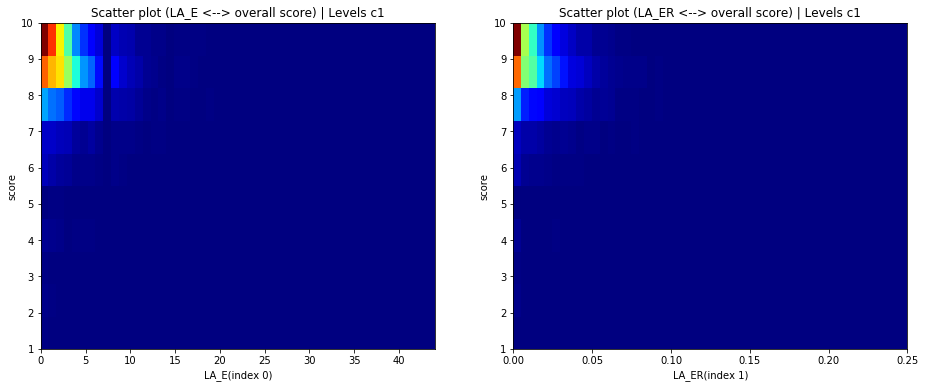

In [5]:

rows = math.ceil(len(feature_names)/3)
columns = 3
plt.figure(figsize=(columns*8, rows*6))

for feature_index, feature_column in enumerate(feature_matrix.T):
    plt.subplot(rows,columns,feature_index+1)
    #plt.scatter(feature_column, scores)
    plt.hist2d(feature_column, scores, (50, 10), cmap=plt.cm.jet)
    plt.title('Scatter plot (' + feature_names[feature_index] + ' <--> overall score) | Levels ' + ','.join([str(level) for level in levels]))
    plt.xlabel(feature_names[feature_index] + "(index " + str(feature_index)+")")
    plt.ylabel('score')
plt.show()

## 3. Correlation measures
We first define a function to easily make bar graphs based on the correlation data

In [6]:
def plot_correlation(x_values,y_values,x_labels,title):
    plt.figure(figsize=(len(x_values), 10))
    rects = plt.bar(np.arange(len(x_values)),y_values,width=1)

    plt.xticks(np.arange(len(x_values)), x_labels)
    plt.title(title)

    for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                    str(round(height,3)),
                    ha='center', va='bottom')

#### 3.1 Linear Regression
showing the correlation coefficient r^2

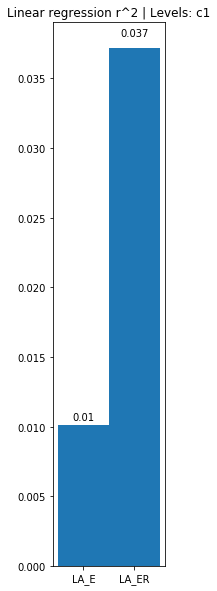

In [7]:
correlation_values = []
for feature_column in feature_matrix.T:
    slope, intercept, r_value, p_value, std_err = stats.linregress(feature_column,scores)
    correlation_values.append(r_value**2)

plot_correlation(np.arange(len(feature_names)),correlation_values, feature_names,"Linear regression r^2 | Levels: " + ', '.join(map(str,levels)))

#### 3.2 Spearman correlation

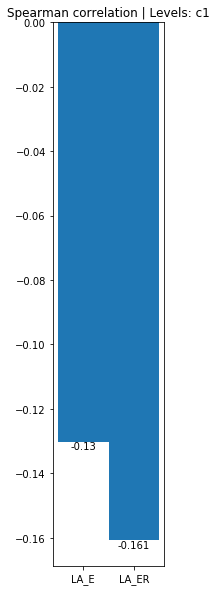

In [8]:
correlation_values = []
for feature_column in feature_matrix.T:
    (corr, p_val) = stats.spearmanr(feature_column,scores)
    correlation_values.append(corr)

plot_correlation(np.arange(len(feature_names)),correlation_values, feature_names,"Spearman correlation | Levels: " + ', '.join(map(str,levels)))


#### 3.3 pearson correlation

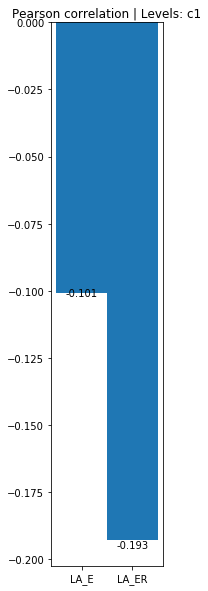

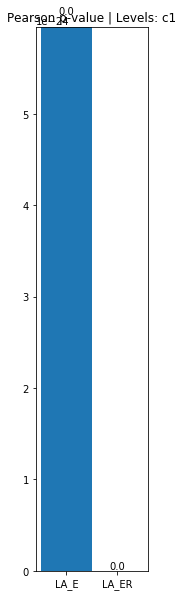

In [9]:
correlation_values = []
p_values = []
for feature_column in feature_matrix.T:
    (corr, p_val) = stats.pearsonr(feature_column,scores)
    correlation_values.append(corr)
    p_values.append(p_val)

plot_correlation(np.arange(len(feature_names)),correlation_values, feature_names,"Pearson correlation | Levels: " + ', '.join(map(str,levels)))
plot_correlation(np.arange(len(feature_names)),p_values, feature_names,"Pearson p-value | Levels: " + ', '.join(map(str,levels)))